In [2]:
!pip install --upgrade keras-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 KB 5.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.8 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 5.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully 

In [23]:
import tensorflow as tf
from tensorflow import keras
import keras_cv

# --- Parameters ---
num_classes = 20
input_size = 224  # can increase to 640 for better detection
bbox_format = "xyxy"  # keras_cv uses "xyxy"

# --- 1. Backbone ---
# MobileNetV3Small without top
backbone = keras.applications.MobileNetV3Small(
    input_shape=(input_size, input_size, 3),
    include_top=False,
    # weights="imagenet",
    alpha=0.75
)

# KerasCV RetinaNet expects a feature pyramid, so we wrap backbone with FPN
backbone_with_fpn = keras_cv.models.MobileNetV3SmallBackbone(
    backbone=backbone,
    input_shape=(input_size, input_size, 3),
    include_rescaling=False,  # MobileNet already expects 0-1 or normalized input
    pyramid_channels=256,
    min_level=3,
    max_level=7
)

# --- 2. RetinaNet model ---
model = keras_cv.models.RetinaNet(
    classes=num_classes,
    num_classes=num_classes,
    bounding_box_format=bbox_format,
    backbone=backbone_with_fpn,
)

# --- 3. Compile ---
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    classification_loss="focal",
    box_loss="smoothl1"
)

model.summary()
# --- 4. Prepare Dataset ---
# Example function to prepare dataset
def preprocess_example(image, boxes, classes):
    # Resize image
    image = tf.image.resize(image, (input_size, input_size))
    image = tf.cast(image, tf.float32) / 255.0
    labels = {
        "boxes": boxes,       # shape [num_objects, 4], format xyxy
        "classes": classes    # shape [num_objects,]
    }
    return image, labels

# Example dataset (replace with your TF dataset)
# train_ds = raw_ds.map(preprocess_example).batch(8).prefetch(tf.data.AUTOTUNE)

# --- 5. Train ---
# model.fit(train_ds, epochs=20, steps_per_epoch=100)

# --- 6. Inference ---
# preds = model.predict(test_images)
# preds is a dict: {"boxes": ..., "scores": ..., "classes": ...}


Model: "retina_net_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ [(None, 28, 28,   │    881,520 │ images[0][0]      │
│ (Functional)        │ 24), (None, 14,   │            │                   │
│                     │ 14, 48), (None,   │            │                   │
│                     │ 7, 7, 96)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_pyramid_7   │ [(None, 28, 28,   │  2,625,536 │ functional_8[0][… │
│ (FeaturePyramid)    │ 256), (None, 14,  │            │ functional_8[0][… │
│                     │ 14, 256), (None,  │            │ functional_8[0][… │
│                     │ 7, 7, 256),       │            │                   │
│                     │ (None, 7, 7,      │            │                   │
│                     │ 256), (None, 7,   │            │                   │
│                     │ 7, 256)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_15  │ (None, 7, 7, 36)  │  1,853,220 │ feature_pyramid_… │
│ (PredictionHead)    │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_14  │ (None, 7, 7, 180) │  2,185,140 │ feature_pyramid_… │
│ (PredictionHead)    │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_70          │ (None, 7056, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_72          │ (None, 1764, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_74          │ (None, 441, 4)    │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_76          │ (None, 441, 4)    │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_78          │ (None, 441, 4)    │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_71          │ (None, 7056, 20)  │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_73          │ (None, 1764, 20)  │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,545,416 (28.78 MB)

 Trainable params: 7,534,456 (28.74 MB)

 Non-trainable params: 10,960 (42.81 KB)

In [3]:
! pip install -qq super_gradients==3.7.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ai-edge-quantizer 0.1.0 requires tensorflow>=2.19.0, which is not installed.
ai-edge-torch 0.4.0 requires tensorflow==2.19.*, which is not installed.
ai-edge-litert 1.2.0 requires numpy>=1.23.2, but you have numpy 1.23.0 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
jax 0.6.2 requires numpy>=1.26, but you have numpy 1.23.0 which is incompatible.
jaxlib 0.6.2 requires numpy>=1.26, but you have numpy 1.23.0 which is incompatible.
label-studio 1.20.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 1.23.0 which is incompatible.
label-studio 1.20.0 requires setuptools>=75.4.0, but you have setuptools 66.1.1 which is incompatible.
label-studio-sdk 1.0.18 requires numpy<3.0.0,>=1.26.4, but you have numpy 1.23.0 which is incompatible.
numba 0.6

In [2]:
!pip uninstall -y numpy tensorflow tensorboard protobuf


Found existing installation: numpy 1.23.0
Uninstalling numpy-1.23.0:
  Successfully uninstalled numpy-1.23.0
Found existing installation: tensorflow 2.19.1
Uninstalling tensorflow-2.19.1:
  Successfully uninstalled tensorflow-2.19.1
Found existing installation: tensorboard 2.19.0
Uninstalling tensorboard-2.19.0:
  Successfully uninstalled tensorboard-2.19.0
Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:


  Successfully uninstalled protobuf-3.20.3


In [1]:
import super_gradients

/home/cat/.env/tf_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
[2025-08-18 18:10:12] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/cat/sg_logs/console.log


/home/cat/.env/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import torch
print(torch.__version__)

f'{torch.cuda.device_count()} GPU found: {torch.cuda.get_device_name("cuda")}'

'1 GPU found: NVIDIA GeForce RTX 2050'

2.6.0+cu124


In [31]:
from super_gradients import Trainer
from super_gradients.training import MultiGPUMode


CHECKPOINT_DIR = '/home/cat/projects/CV-stuff/latl/classification/ckpt_folder' # Local path
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolox', ckpt_root_dir=CHECKPOINT_DIR)

In [2]:

from super_gradients.training import models
# from super_gradients.training.utils.checkpoint_utils import load_checkpoint_to_model

# checkpoint_path = "/home/cat/projects/CV-stuff/latl/classification/helper-models/yolox_n_coco.pth"
# state_dict = torch.load(checkpoint_path, weights_only=False)
model = models.get("yolox_n", num_classes=80, pretrained_weights="coco")


# model.load_state_dict(state_dict, strict=False)

# load_checkpoint_to_model(net=model, ckpt_local_path=checkpoint_path)

print('Num classes in the model:', model.num_classes)

/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/common/deprecate.py:279: DeprecationWarning: Parameter `arch_params.channels_in` is deprecated since version `3.3.0` and will be removed in version `4.0.0`.
Please update your code to use the `arch_params.in_channels` instead of `arch_params.channels_in`.
  warnings.warn(message, DeprecationWarning)
[2025-08-18 18:10:51] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2025-08-18 18:10:51] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


Num classes in the model: 80


In [4]:
!pip install torch

    click (>=7.0<=8.1.*)
          ~~~~~~^


In [20]:
!pip install numpy==1.26


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 4.9 MB/s  0:00:03m0:00:0100:01
    click (>=7.0<=8.1.*)
          ~~~~~~^
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio 1.20.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 1.26.0 which is incompatible.
label-studio 1.20.0 requires setuptools>=75.4.0, but you have setuptools 66.1.1 which is incompatible.
label-studio-sdk 1.0.18 requires numpy<3.0.0,>=1.26.4, but you have numpy 1.26.0 which is incompatible.
streamlit 1.35.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.5 which is incompatible.
super-gradients 3.7.1 requires numpy<=1.23, but you have numpy 1.26.0 which is incompatible.
super-gradients 3.7.1 requires protobuf==3.20.

In [29]:
# !onnx2tf -i /home/cat/projects/CV-stuff/latl/classification/notebooks/yolo_x_nano.onnx
!onnx2tf -i /home/cat/projects/CV-stuff/latl/classification/notebooks/yolo_x_nano.onnx -oiqt -qcind images YOLOX_outputs\yolox_nano_ti_lite_nu\calib_data_320x320_n200.npy "[[[[0,0,0]]]]" "[[[[1,1,1]]]]"

E0000 00:00:1755537921.573410  322678 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755537921.576773  322678 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755537921.586298  322678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755537921.586318  322678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755537921.586319  322678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755537921.586321  322678 computation_placer.cc:177] computation placer already registered. Please check linka

[2025-08-18 16:13:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


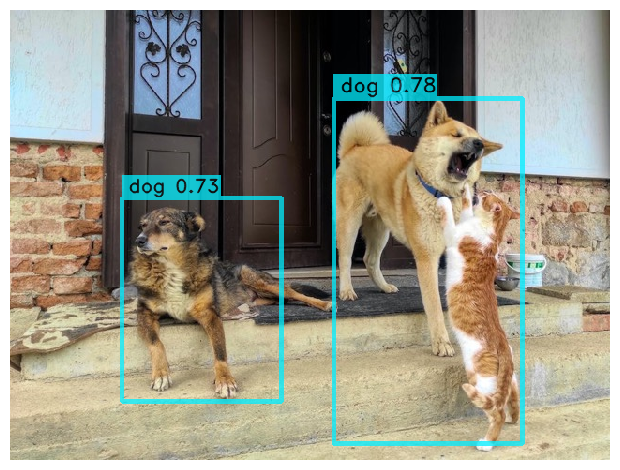

In [62]:
predictions = model.predict("https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/images/examples/dogs_and_cat.jpeg?raw=true", conf=0.70) # You can play with the `conf` and `iou` parameters
predictions.show()

In [12]:
import sys
import os
from super_gradients.training import models

# Redirect stderr to avoid the closed file issue
stderr_fileno = sys.stderr
sys.stderr = open(os.devnull, 'w')

try:
    model = models.get("yolox_n", pretrained_weights="coco")
    model.eval()
    model.export("yolo_x_nano.onnx")
finally:
    sys.stderr.close()
    sys.stderr = stderr_fileno


[2025-08-18 16:48:41] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2025-08-18 16:48:41] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


In [1]:
import tensorflow as tf
print(tf.__version__)


2025-08-18 17:42:40.780924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 17:42:40.797702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755531760.809210  242679 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755531760.812395  242679 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755531760.822060  242679 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.19.1


In [2]:
import cv2
import numpy as np

def letterbox_image(image, max_size=640, color=(114, 114, 114)):
    h, w = image.shape[:2]
    scale = max_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize while keeping aspect ratio
    resized_image = cv2.resize(image, (new_w, new_h))
    
    # Create padded image
    padded_image = np.full((max_size, max_size, 3), color, dtype=np.uint8)
    
    # Compute top-left corner for placing resized image
    top = (max_size - new_h) // 2
    left = (max_size - new_w) // 2
    
    padded_image[top:top+new_h, left:left+new_w] = resized_image
    return padded_image


In [6]:
import cv2
import numpy as np
from super_gradients.training.utils.media.image import load_image
import onnxruntime

image = load_image("https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/images/examples/dogs_and_cat.jpeg?raw=true")

image = letterbox_image(image, max_size=640)
image_bchw = np.transpose(np.expand_dims(image, 0), (0, 3, 1, 2))

session = onnxruntime.InferenceSession("yolo_x_nano.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
result = session.run(outputs, {inputs[0]: image_bchw})

image_bchw.shape, result[0].shape, result[1].shape, result[2].shape, result[3].shape

((1, 3, 640, 640), (1, 1), (1, 1000, 4), (1, 1000), (1, 1000))

/home/cat/.env/tf_env/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [27]:
from super_gradients.training.datasets.datasets_conf import COCO_DETECTION_CLASSES_LIST
from super_gradients.training.utils.detection_utils import DetectionVisualization
import matplotlib.pyplot as plt


def show_predictions_from_batch_format(image, predictions, conf=0.5):
    num_predictions, pred_boxes, pred_scores, pred_classes = predictions

    assert num_predictions.shape[0] == 1, "Only batch size of 1 is supported by this function"

    num_predictions = int(num_predictions.item())
    print(num_predictions)
    pred_boxes = pred_boxes[0, :num_predictions]
    pred_scores = pred_scores[0, :num_predictions]
    pred_classes = pred_classes[0, :num_predictions]

    image = image.copy()
    class_names = COCO_DETECTION_CLASSES_LIST
    color_mapping = DetectionVisualization._generate_color_mapping(len(class_names))

    for (x1, y1, x2, y2, class_score, class_index) in zip(pred_boxes[:, 0], pred_boxes[:, 1], pred_boxes[:, 2], pred_boxes[:, 3], pred_scores, pred_classes):
        # print(class_score)
        if class_score>=conf:
            image = DetectionVisualization.draw_box_title(
                image_np=image,
                x1=int(x1),
                y1=int(y1),
                x2=int(x2),
                y2=int(y2),
                class_id=class_index,
                class_names=class_names,
                color_mapping=color_mapping,
                box_thickness=2,
                pred_conf=class_score,
            )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


6


/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


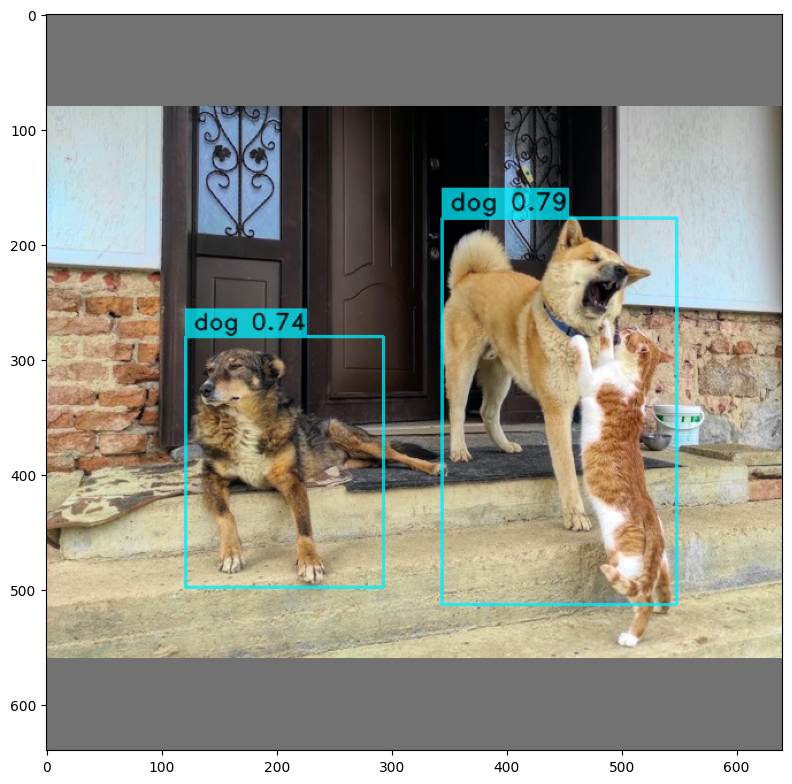

In [28]:
show_predictions_from_batch_format(image, result, conf=0.7)

In [45]:
from super_gradients.training import training_hyperparams


train_params = training_hyperparams.get('coco2017_yolox')

train_params

{'resume': None,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'CosineLRScheduler',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 5,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 15,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.05,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'SGD',
 'optimizer_params': {'momentum': 0.9, 'weight_decay': 0.0005, 'nesterov': True},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': True,
 'loss': 'YoloXDetectionLoss',
 'criterion_params': {'strides': [8, 16, 32], 'num_classes': 80},
 'ema': True,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [],
 'valid_metrics_list': [{'DetectionMetrics': {'normalize_targets': True, 'post_prediction_callback': YoloXPostPredictionCallback(), 'num_cls': 80}}],
 'metric_to_watch': 'mAP

In [46]:

train_params['max_epochs'] = 5
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = 48
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.0005
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False

In [47]:
model

YoloX_N(
  (_backbone): YoloDarknetBackbone(
    (_modules_list): ModuleList(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): GroupedConvBlock(
        (dconv): Conv(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (conv): Conv(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (2): CSPLayer(
        (conv1): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=Fal